In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Step 1: Define star vectors as plane normal

In [2]:
# star 3D
phi = (1+np.sqrt(5))/2
v_iter = [[0,1,phi],[1,phi,0],[phi,0,1]]

e = []
alpha = []
for v in v_iter:
    for i in range(8):
        i_0 = i%2
        i_1 = ((i-i_0)/2)%2
        i_2 = ((((i-i_0)/2)-i_1)/2)%2
        sgn = np.array([i_0,i_1,i_2])*2-1
                
        if sgn[np.where(np.array(v)==0)]==-1:
            continue
            
        v_signed = [v[x]*sgn[x] for x in range(3)]
#         if np.dot(v_signed,[0,1,phi])<0:
#             continue
        e.append(v_signed)
        alpha.append(1)
alpha = np.array(alpha)/100
e = np.array(e)
e = e/np.sqrt(1**2+phi**2)
e

# e = [[1,0,0],[0,1,0],[0,0,1]]
# e = np.array(e)

array([[ 0.        , -0.52573111, -0.85065081],
       [ 0.        ,  0.52573111, -0.85065081],
       [ 0.        , -0.52573111,  0.85065081],
       [ 0.        ,  0.52573111,  0.85065081],
       [-0.52573111, -0.85065081,  0.        ],
       [ 0.52573111, -0.85065081,  0.        ],
       [-0.52573111,  0.85065081,  0.        ],
       [ 0.52573111,  0.85065081,  0.        ],
       [-0.85065081,  0.        , -0.52573111],
       [ 0.85065081,  0.        , -0.52573111],
       [-0.85065081,  0.        ,  0.52573111],
       [ 0.85065081,  0.        ,  0.52573111]])

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


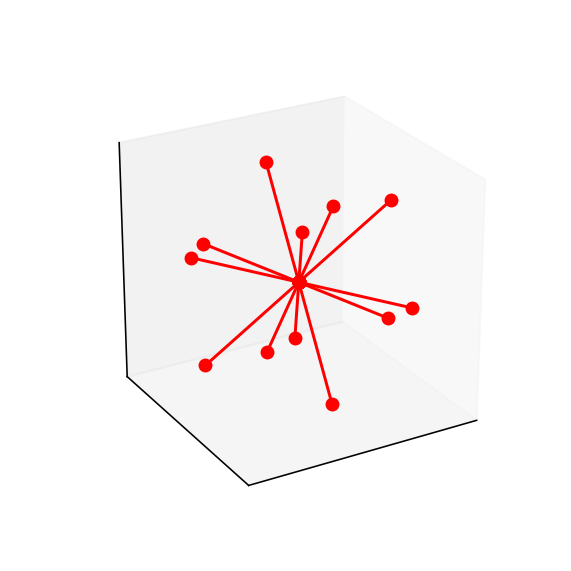

In [4]:
fig = plt.figure(figsize=(4,4))
fig.tight_layout()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.view_init(elev=25, azim=60)
# ax.axis('equal')

for i in range(len(e)):
    ax.plot([0,e[i,0]],[0,e[i,1]],[0,e[i,2]],'-or')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

## Step 2: Generate duals from intersections

<IPython.core.display.Javascript object>


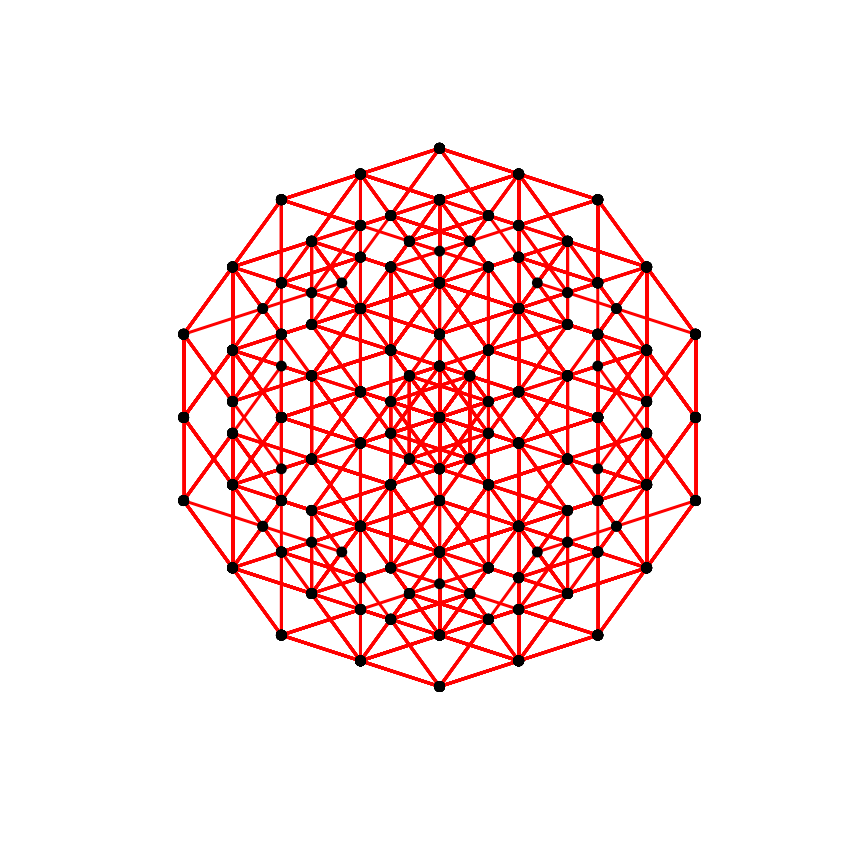

In [5]:
def vol(s,j,k):
    return np.dot(e[s,:],np.cross(e[j,:],e[k,:]))

# create dump file
dumpname = 'test_GDM_3D.dump'
f = open(dumpname, 'w')
f.write('ITEM: TIMESTEP\n');
f.write('0\n');
f.write('ITEM: NUMBER OF ATOMS\n');
f.write('ITEM: BOX BOUNDS xx yy zz\n');
f.write('-8 8\n');
f.write('-8 8\n');
f.write('-8 8\n');
f.write('ITEM: ATOMS id type xu yu zu\n');
f.close()

# create figure
fig = plt.figure(figsize=(6,6))
# fig.tight_layout()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_proj_type('ortho')
ax.view_init(elev=7, azim=-66)
ax.view_init(elev=58.2825, azim=-90)
# ax.view_init(elev=36, azim=135)
ax._axis3don = False

# begin iteration
tripletscount = 0
vertscount = 0
for j in range(len(e)-2):
    for k in range(j+1,len(e)-1):
        for s in range(k+1,len(e)):
            l = [x for x in range(len(e)) if x not in [j,k,s]]

            vol_sjk = vol(s,j,k)
            vol_ksj = vol(k,s,j)
            vol_jks = vol(j,k,s)
            
            tol = 1e-12
            if np.abs(vol_sjk)<tol: # avoid flat parallelepiped
                continue
            tripletscount += 1
            
            u_sjk = np.cross(e[j,:],e[k,:])/vol_sjk
            u_ksj = np.cross(e[s,:],e[j,:])/vol_ksj
            u_jks = np.cross(e[k,:],e[s,:])/vol_jks
            
            n_strips = 1
            n_c = (n_strips-1)/2 # index of center strip

            for i_j in range(n_strips):
                for i_k in range(n_strips):
                    for i_s in range(n_strips):

                        n_j = i_j-n_c
                        n_k = i_k-n_c
                        n_s = i_s-n_c
#                         sum_i_jks = abs(n_j)+abs(n_k)+abs(n_s)
#                         if sum_i_jks > 1: 
#                             continue

                        x_n_j = n_j + alpha[j] #+ np.floor(n_j*sigma[j])/rho[j]
                        x_n_k = n_k + alpha[k] #+ np.floor(n_k*sigma[k])/rho[k]
                        x_n_s = n_s + alpha[s] #+ np.floor(n_s*sigma[s])/rho[s]

                        e_zero = n_j*e[j,:] + n_k*e[k,:] + n_s*e[s,:]
                        
                        sum_i_l = 0
                        for i_l in range(len(l)):
                            vol_ljk = vol(l[i_l],j,k)
                            vol_lsj = vol(l[i_l],s,j)
                            vol_lks = vol(l[i_l],k,s)
                            x_n_l = (x_n_s*vol_lsj/vol_sjk+
                                     x_n_j*vol_ljk/vol_jks+
                                     x_n_k*vol_lks/vol_ksj)
                            e_zero += (np.floor(x_n_l - alpha[l[i_l]]))*e[l[i_l],:];
                        
                        t_0 = e_zero
                        t_1 = t_0 - e[s,:]
                        t_2 = t_0 - e[j,:]
                        t_3 = t_0 - e[k,:]
                        t_4 = t_0 - e[j,:] - e[k,:]
                        t_5 = t_0 - e[s,:] - e[j,:]
                        t_6 = t_0 - e[k,:] - e[s,:]
                        t_7 = t_0 - e[s,:] - e[j,:] - e[k,:]
                        
                        ts = np.array([t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7])
                        ds = np.array([np.sqrt(np.sum(x**2)) for x in ts])
                        pgs = np.array([
                               [t_0,t_2,t_4,t_3],
                               [t_1,t_5,t_7,t_6],
                               [t_0,t_1,t_5,t_2],
                               [t_3,t_6,t_7,t_4],
                               [t_0,t_3,t_6,t_1],
                               [t_2,t_4,t_7,t_5],
                              ])
                        
                        
#                         ax.plot([t_0[0],t_1[0],t_3[0],t_2[0],t_0[0]],[t_0[1],t_1[1],t_3[1],t_2[1],t_0[1]],'-k')
#                         if (ds>3).any():
#                             continue
                        ax.scatter([t_0[0],t_1[0],t_2[0],t_3[0],t_4[0],t_5[0],t_6[0],t_7[0]],
                                   [t_0[1],t_1[1],t_2[1],t_3[1],t_4[1],t_5[1],t_6[1],t_7[1]],
                                   [t_0[2],t_1[2],t_2[2],t_3[2],t_4[2],t_5[2],t_6[2],t_7[2]],
                                   'o',fc='k',ec='k',alpha=1)
                        for pg in pgs:
                            ax.plot(pg[:,0],pg[:,1],pg[:,2],'-r')
#                         ax.add_collection3d(Poly3DCollection(pgs, 
#                                             facecolors='r', linewidths=1, edgecolors='k', alpha=.75))
                        
                        # export vertices
                        f = open(dumpname,'a')
                        for v in ts:
                            f.write('{:d} 1 {:2.8e} {:2.8e} {:2.8e}\n'.format(vertscount,v[0],v[1],v[2]));
                            f.close
                            vertscount += 1

lines = []
with open(dumpname,"r") as f:
    for line in f:
        lines.append(line)
    f.close()
lines.insert(3, "{:d}\n".format(vertscount))
s = ''.join(lines)
with open(dumpname,"w") as f:
    f.write(s)
    f.close()

                            
box_size = 2.5
ax.set_xlim(-box_size,box_size)
ax.set_ylim(-box_size,box_size)
ax.set_zlim(-box_size,box_size)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.tight_layout()

pngname = 'test_GDM_3D.png'
plt.savefig(pngname, dpi=300, bbox_inches='tight')

plt.show()

## Backups